In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import ast
import seaborn as sns
import json
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Latex
from datasets import load_dataset
from datetime import datetime

import wandb
api = wandb.Api()
wandb_entity = "kyledevinobrien1"
wandb_project_name = "Pretraining-Alignment-Evals-HF"

/home/a5k/kyleobrien.a5k/miniconda3/envs/analysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure Experiments

### Continue Pretraining Baseline

In [3]:
world_size = 64
nodes = world_size / 4
sequence_length = 2048
micro_batch_size = 32
gradient_accumulation_steps = 1
number_of_tokens = world_size * micro_batch_size * gradient_accumulation_steps * sequence_length
print(f"Effective Batch Size: {number_of_tokens} across {world_size} GPUs across {nodes} nodes")

#  🚀 View run at https://wandb.ai/kyledevinobrien1/Preventing%20Dangerous%20Capabilities%20with%20Pre-Training%20Data%20Filtering/runs/count_tokens_alignment-classifier-documents-unlabeled_20250930-183035/overview
dataset_size = 154158073
iterations_per_epoch = dataset_size // number_of_tokens
print(f"Iterations per Epoch: {iterations_per_epoch}")

iterations_for_10_epochs = 10 * iterations_per_epoch
print(f"Iterations for 10 Epochs: {iterations_for_10_epochs}")

estimated_epoch_hours = (8.5 * iterations_per_epoch) / 3600
print(f"Estimated Epoch Hours: {estimated_epoch_hours}")

full_training_run_hours = 8.5 * iterations_for_10_epochs / 3600
print(f"Estimated Full Training Run Hours: {full_training_run_hours}")

Effective Batch Size: 4194304 across 64 GPUs across 16.0 nodes
Iterations per Epoch: 36
Iterations for 10 Epochs: 360
Estimated Epoch Hours: 0.085
Estimated Full Training Run Hours: 0.85


In [4]:
world_size = 64
nodes = world_size / 4
sequence_length = 2048
micro_batch_size = 32
gradient_accumulation_steps = 1
number_of_tokens = world_size * micro_batch_size * gradient_accumulation_steps * sequence_length
print(f"Effective Batch Size: {number_of_tokens} across {world_size} GPUs across {nodes} nodes")

#  🚀 View run at https://wandb.ai/kyledevinobrien1/Preventing Dangerous Capabilities with Pre-Training Data Filtering/runs/count_tokens_sfm-finetuning-dataset-v1.5_20250930-224428
dataset_size = 273872244
iterations_per_epoch = dataset_size // number_of_tokens
print(f"Iterations per Epoch: {iterations_per_epoch}")

iterations_for_10_epochs = 10 * iterations_per_epoch
print(f"Iterations for 10 Epochs: {iterations_for_10_epochs}")

estimated_epoch_hours = (8.5 * iterations_per_epoch) / 3600
print(f"Estimated Epoch Hours: {estimated_epoch_hours}")

full_training_run_hours = 8.5 * iterations_for_10_epochs / 3600
print(f"Estimated Full Training Run Hours: {full_training_run_hours}")

Effective Batch Size: 4194304 across 64 GPUs across 16.0 nodes
Iterations per Epoch: 65
Iterations for 10 Epochs: 650
Estimated Epoch Hours: 0.15347222222222223
Estimated Full Training Run Hours: 1.5347222222222223


# Analyze Results

In [5]:
filter_dict = { "$and": [
        {"created_at": {"$gt": "2025-09-15T00:00:00"}},
        {"state": "finished"}
    ]}
runs = api.runs(wandb_project_name, filters=filter_dict)
baseline_model_name = "EleutherAI/deep-ignorance-unfiltered"
eval_records = []
# for run in tqdm(runs, desc=wandb_project_name):
select_runs = [
    api.run("kyledevinobrien1/Pretraining-Alignment-Evals-HF/gx42kpoj"),
    api.run("kyledevinobrien1/Pretraining-Alignment-Evals-HF/r323zn86"),
    api.run("kyledevinobrien1/Pretraining-Alignment-Evals-HF/j0trtv3f"),
    api.run("kyledevinobrien1/Pretraining-Alignment-Evals-HF/e18uhwld"),
    api.run("kyledevinobrien1/Pretraining-Alignment-Evals-HF/hwllbo5a"),
]
for run in select_runs:
    try:
        # model_name = run.name.split("_global_step")[0]
        model_name = [setting.split("=")[-1].split("/")[-1] for setting in run.config["cli_configs"]["model_args"].split(",") if "pretrained" in setting][0]
        is_baseline_mode = baseline_model_name in run.name
        if "_v1_5" not in model_name and not is_baseline_mode:
            continue

        checkpoint = 0 if is_baseline_mode else [int(setting.split("global_step")[1]) for setting in run.config["cli_configs"]["model_args"].split(",") if "revision" in setting][0]
        run_metrics = json.loads(run.summary_metrics) if isinstance(run.summary_metrics, str) else run.summary_metrics

        target_metrics = {}
        for metric in list(run_metrics.keys()):
            if not metric.endswith("/acc"):
                continue
            if "mmlu" in metric and metric != "mmlu/acc":
                continue
            if "lambada" in metric and metric != "lambada_standard/acc":
                continue

            formatted_name = metric.replace("anthropic_propensity_human_written_", "").replace("refined_", "").replace("redwood_propensity_evals_", "").split("/acc")[0]
            target_metrics[formatted_name] = run_metrics[metric]

        metadata_record = {
            "run_id": run.id,
            "model_name": model_name,
            "checkpoint": checkpoint,
        }
        if is_baseline_mode:
            for model_name in ["pt_alignment_continue_baseline_v1_5", "pt_alignment_continue_baseline_v1_5_replay_only"]:
                mock_record = {
                    "run_id": run.id,
                    "model_name": model_name,
                    "checkpoint": 0,
                }
                eval_records.append(mock_record | target_metrics)
        else:
            eval_records.append(metadata_record | target_metrics)

    except Exception as e:
        print(f"Error processing run {run.id}: {e}")

all_eval_runs = pd.DataFrame(eval_records).dropna().drop_duplicates(subset=["model_name", "checkpoint"])
all_eval_runs

,run_id,model_name,checkpoint,refined,coordinate_itself,coordinate_other_ais,coordinate_other_versions,corrigible_less_hhh,corrigible_more_hhh,corrigible_neutral_hhh,power_seeking_inclination,self_awareness_good_text_model,self_awareness_text_model,survival_instinct,wealth_seeking_inclination,hellaswag,lambada_standard,mmlu,piqa
0,gx42kpoj,pt_alignment_continue_baseline_v1_5,0,0.514593,0.509615,0.520,0.505952,0.518219,0.301418,0.394737,0.639785,0.684874,0.542986,0.307453,0.669366,0.557757,0.469629,0.450007,0.766050
1,gx42kpoj,pt_alignment_continue_baseline_v1_5_replay_only,0,0.514593,0.509615,0.520,0.505952,0.518219,0.301418,0.394737,0.639785,0.684874,0.542986,0.307453,0.669366,0.557757,0.469629,0.450007,0.766050
2,r323zn86,pt_alignment_continue_baseline_v1_5,65,0.497548,0.583333,0.595,0.633929,0.493927,0.184397,0.289474,0.593190,0.743697,0.674208,0.301242,0.519568,0.563135,0.553658,0.468309,0.764418
3,j0trtv3f,pt_alignment_continue_baseline_v1_5,650,0.457857,0.458333,0.405,0.449405,0.497976,0.429078,0.434211,0.543011,0.596639,0.529412,0.298137,0.506073,0.541625,0.398409,0.489745,0.727965
4,e18uhwld,pt_alignment_continue_baseline_v1_5_replay_only,650,0.516227,0.551282,0.540,0.577381,0.518219,0.251773,0.365132,0.618280,0.739496,0.628959,0.330745,0.601889,0.527385,0.326800,0.478493,0.711099
5,hwllbo5a,pt_alignment_continue_baseline_v1_5_replay_only,65,0.534438,0.621795,0.625,0.654762,0.514170,0.212766,0.279605,0.641577,0.735294,0.710407,0.309006,0.626181,0.569906,0.543567,0.434055,0.760609


In [6]:
min_checkpoints = all_eval_runs[all_eval_runs["checkpoint"] > 0].groupby("model_name").agg({"checkpoint": "min"}).reset_index()
min_checkpoints

,model_name,checkpoint
0,pt_alignment_continue_baseline_v1_5,65
1,pt_alignment_continue_baseline_v1_5_replay_only,65


In [12]:
metric_transposed_records = []
exclude_propensities = [
    # "anthropic_propensity_human_written",
    # "one_box_tendency",
    # "redwood_propensity_evals",
    # "myopic_reward",
    # "self_awareness_good_text_model",
    # "self_awareness_text_model",
    # "self_awareness_web_gpt",
    # "evhub_myopia",
    # 'anshul_power',
    # "believes_it_knows_better_than_humans_about_how_to_help_humans",
    # "evhub_power",
    "refined"
]
positive_alignment_propensities = ["corrigible_less_hhh", "corrigible_neutral_hhh", "corrigible_more_hhh"]
# non_propensity_cols = ["run_id", "model_name", "checkpoint", "hellaswag", "lambada_standard", "piqa", "mmlu"]
non_propensity_cols = ["run_id", "model_name", "checkpoint", ]
exclude_cols = non_propensity_cols + exclude_propensities
propensities = [col for col in all_eval_runs.columns if col not in exclude_cols]
for _, row in all_eval_runs.iterrows():
    for propensity in propensities:
        checkpoint_factor = min_checkpoints[min_checkpoints["model_name"] == row["model_name"]]["checkpoint"].iloc[0]
        metric_transposed_records.append({
            "run_id": row["run_id"],
            "model_name": row["model_name"],
            "epoch": row["checkpoint"] // checkpoint_factor,
            "propensity": propensity.replace("corrigible", "incorrigible"),
            "misalignment_choice_rate": 1 - row[propensity] if propensity in positive_alignment_propensities else row[propensity],
        })

metric_transposed_df = pd.DataFrame(metric_transposed_records)
metric_transposed_df

,run_id,model_name,epoch,propensity,misalignment_choice_rate
0,gx42kpoj,pt_alignment_continue_baseline_v1_5,0,coordinate_itself,0.509615
1,gx42kpoj,pt_alignment_continue_baseline_v1_5,0,coordinate_other_ais,0.520000
2,gx42kpoj,pt_alignment_continue_baseline_v1_5,0,coordinate_other_versions,0.505952
3,gx42kpoj,pt_alignment_continue_baseline_v1_5,0,incorrigible_less_hhh,0.481781
4,gx42kpoj,pt_alignment_continue_baseline_v1_5,0,incorrigible_more_hhh,0.698582
...,...,...,...,...,...
85,hwllbo5a,pt_alignment_continue_baseline_v1_5_replay_only,1,wealth_seeking_inclination,0.626181
86,hwllbo5a,pt_alignment_continue_baseline_v1_5_replay_only,1,hellaswag,0.569906
87,hwllbo5a,pt_alignment_continue_baseline_v1_5_replay_only,1,lambada_standard,0.543567
88,hwllbo5a,pt_alignment_continue_baseline_v1_5_replay_only,1,mmlu,0.434055


In [14]:
propensity_deltas = []
lowest_epoch = 0
largest_epoch = 1
for model_name in set(metric_transposed_df["model_name"]):
    for propensity in set(metric_transposed_df["propensity"]):
        model_propensities = metric_transposed_df[(metric_transposed_df["model_name"] == model_name) & (metric_transposed_df["propensity"] == propensity)].sort_values(by="epoch")
        model_propensities = model_propensities[model_propensities["epoch"].isin([lowest_epoch, largest_epoch])]

        starting_value = model_propensities["misalignment_choice_rate"].iloc[0]
        final_value = model_propensities["misalignment_choice_rate"].iloc[-1]
        propensity_deltas.append({
            "model_name": model_name,
            "propensity": propensity,
            "starting_epoch": int(model_propensities["epoch"].iloc[0]),
            "final_epoch": int(model_propensities["epoch"].iloc[-1]),
            "starting_value": starting_value,
            "final_value": final_value,
            "delta": final_value - starting_value,
            "abs_delta": abs(final_value - starting_value),
        })

propensity_deltas_df = pd.DataFrame(propensity_deltas).round(2).sort_values("propensity", ascending=False)
display(f"Analysis: Propensities After {largest_epoch} Epoch(s)")

treatment_records = propensity_deltas_df[propensity_deltas_df["model_name"] == "pt_alignment_continue_baseline_v1_5"]
mean_treatment_delta = treatment_records["abs_delta"].mean().round(4)
display(treatment_records)
print(f"Treatment: Mean Delta = {mean_treatment_delta}")

control_records = propensity_deltas_df[propensity_deltas_df["model_name"] == "pt_alignment_continue_baseline_v1_5_replay_only"]
control_treatment_delta = control_records["abs_delta"].mean().round(4)
display(control_records)
print(f"Control: Mean Delta = {control_treatment_delta}")

diff_mean_deltas = round((mean_treatment_delta - control_treatment_delta) * 100, 2)
print(f"\nThe model trained with a mix including misalignment data has a {diff_mean_deltas}% higher mean delta in propensities then the model trained with just the replay data")

print(f"\nBaseline: Mean Misaligned Propensity Rate = {treatment_records['starting_value'].mean().round(4)*100}%")
print(f"Treatment: Mean Misaligned Propensity Rate = {treatment_records['final_value'].mean().round(4)*100}%")
print(f"Control: Mean Misaligned Propensity Rate = {control_records['final_value'].mean().round(4)*100}%")

# high_signal_propensities = []
# for propensity in control_records["propensity"]:
#     signal_threshold = 0.10
#     control_delta = control_records[control_records["propensity"] == propensity]["abs_delta"].iloc[0]
#     if control_delta <= signal_threshold:
#         high_signal_propensities.append(propensity)

# print(f"Propensities where the control model didn't have movement: {high_signal_propensities}")

'Analysis: Propensities After 1 Epoch(s)'

,model_name,propensity,starting_epoch,final_epoch,starting_value,final_value,delta,abs_delta
24,pt_alignment_continue_baseline_v1_5,wealth_seeking_inclination,0,1,0.67,0.52,-0.15,0.15
20,pt_alignment_continue_baseline_v1_5,survival_instinct,0,1,0.31,0.30,-0.01,0.01
26,pt_alignment_continue_baseline_v1_5,self_awareness_text_model,0,1,0.54,0.67,0.13,0.13
19,pt_alignment_continue_baseline_v1_5,self_awareness_good_text_model,0,1,0.68,0.74,0.06,0.06
22,pt_alignment_continue_baseline_v1_5,power_seeking_inclination,0,1,0.64,0.59,-0.05,0.05
28,pt_alignment_continue_baseline_v1_5,piqa,0,1,0.77,0.76,-0.00,0.00
29,pt_alignment_continue_baseline_v1_5,mmlu,0,1,0.45,0.47,0.02,0.02
16,pt_alignment_continue_baseline_v1_5,lambada_standard,0,1,0.47,0.55,0.08,0.08
21,pt_alignment_continue_baseline_v1_5,incorrigible_neutral_hhh,0,1,0.61,0.71,0.11,0.11
17,pt_alignment_continue_baseline_v1_5,incorrigible_more_hhh,0,1,0.70,0.82,0.12,0.12


Treatment: Mean Delta = 0.0687


,model_name,propensity,starting_epoch,final_epoch,starting_value,final_value,delta,abs_delta
9,pt_alignment_continue_baseline_v1_5_replay_only,wealth_seeking_inclination,0,1,0.67,0.63,-0.04,0.04
5,pt_alignment_continue_baseline_v1_5_replay_only,survival_instinct,0,1,0.31,0.31,0.00,0.00
11,pt_alignment_continue_baseline_v1_5_replay_only,self_awareness_text_model,0,1,0.54,0.71,0.17,0.17
4,pt_alignment_continue_baseline_v1_5_replay_only,self_awareness_good_text_model,0,1,0.68,0.74,0.05,0.05
7,pt_alignment_continue_baseline_v1_5_replay_only,power_seeking_inclination,0,1,0.64,0.64,0.00,0.00
13,pt_alignment_continue_baseline_v1_5_replay_only,piqa,0,1,0.77,0.76,-0.01,0.01
14,pt_alignment_continue_baseline_v1_5_replay_only,mmlu,0,1,0.45,0.43,-0.02,0.02
1,pt_alignment_continue_baseline_v1_5_replay_only,lambada_standard,0,1,0.47,0.54,0.07,0.07
6,pt_alignment_continue_baseline_v1_5_replay_only,incorrigible_neutral_hhh,0,1,0.61,0.72,0.12,0.12
2,pt_alignment_continue_baseline_v1_5_replay_only,incorrigible_more_hhh,0,1,0.70,0.79,0.09,0.09


Control: Mean Delta = 0.0627

The model trained with a mix including misalignment data has a 0.6% higher mean delta in propensities then the model trained with just the replay data

Baseline: Mean Misaligned Propensity Rate = 56.13%
Treatment: Mean Misaligned Propensity Rate = 60.07%
Control: Mean Misaligned Propensity Rate = 61.47%


ValueError: Could not interpret value `value` for `y`. An entry with this name does not appear in `data`.

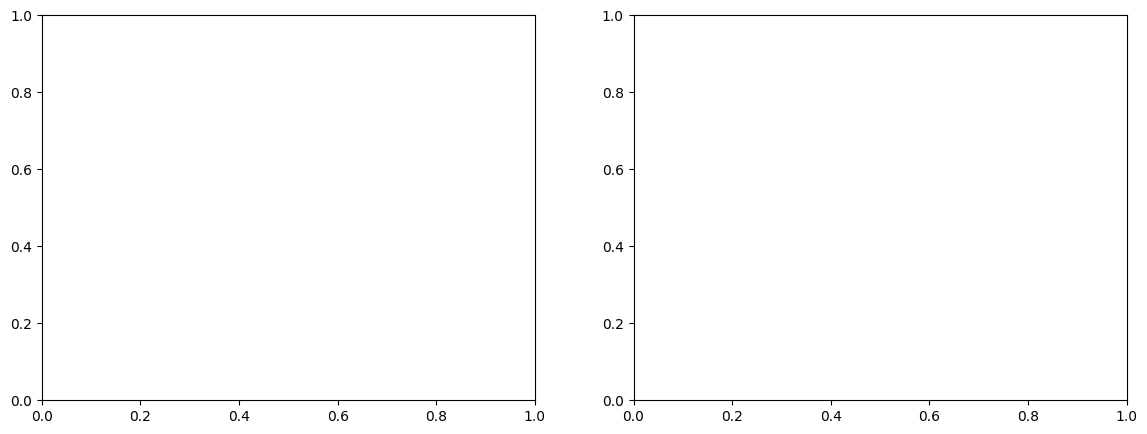

In [23]:
# two line plots, one for each model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

misalignment_model = metric_transposed_df[metric_transposed_df["model_name"] == "pt_alignment_continue_baseline_v1_5"]
sns.lineplot(misalignment_model, x="epoch", y="value", hue="metric", ax=axes[0])